This note describes how to obtain intemediate activation in arbitrary Neural Network written in pytorch.

In [90]:
#module import 
import sys 

import numpy as np
from PIL import Image

import torch
import torchvision


From torchvision, there are many models pretrained by ImageNet.

In [66]:
# model load 
model = torchvision.models.alexnet(pretrained=True)
#model = torchvision.models.vgg19(pretrained=True)
#model = torchvision.models.resnet50(pretrained=True)
# to eavalution mode (since we don't train anymore)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

we now check the architecture of alexnet

In [67]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [75]:
print(model.classifier[4])

Linear(in_features=4096, out_features=4096, bias=True)


In the pytorch we can extract activation of intermediate layers using `register_forward_hook` (refering to  https://forums.fast.ai/t/pytorch-best-way-to-get-at-intermediate-layers-in-vgg-and-resnet/5707/6)

In [69]:
outputs= []
def hook(module, input, output):
    outputs.append(output)

# add hook
model.classifier[4].register_forward_hook(hook)


To check to extract feature correcly, We try to input (random) image

In [70]:
image = np.random.randint(0,255, (224,224,3))

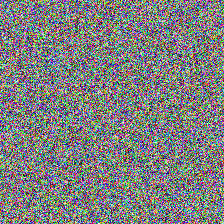

In [71]:
# show this image
Image.fromarray(image.astype(np.uint8))

In [73]:
image_for_torch = torch.Tensor(image.transpose(2,0,1)[np.newaxis])
result = model(image_for_torch)

In [78]:
# the intermediate output is restored at outputs (not reuslt !!)
outputs[0].shape # the shape is batch_size x activation vector(or matrix/tensor)

torch.Size([1, 4096])

Let's try another net 

In [79]:
model = torchvision.models.resnet50(pretrained=True)
# to eavalution mode (since we don't train anymore)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Resnet is more complicated, but we can detect the target layer such as

In [86]:
#model.layer2
model.layer2[3]
#model.layer2[3].conv3

Bottleneck(
  (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

So we can extract intermediate activation in the same way

In [87]:
outputs= []
def hook(module, input, output):
    outputs.append(output)

# add hook
model.layer2[3].conv3.register_forward_hook(hook)

In [89]:
# forward model
result = model(image_for_torch)
# the intermediate output is restored at outputs (not reuslt !!)
outputs[0].shape # the shape is batch_size x activation vector(or matrix/tensor)

torch.Size([1, 512, 28, 28])

From the previous section, we understood how to extract the features. 

  The points are 
  
  
  ・determine the target layer
  
  
  ・using `register_forward_hook`
  
  
So, I created fuction to easily extracting intermediate layer at `cnn_preferred/utils.py`

In [92]:
sys.path.append('../cnn_preferred')
from utils import get_cnn_features

the inputs of `get_cnn_features` are 1) target_model, 2) input_to_model, and 3) target_feature

In [93]:
# 1) target_model
model = torchvision.models.resnet50(pretrained=True)
model.eval()

# 2) input_to_model (image in this example)
image = np.random.randint(0,255, (224,224,3))
image_for_torch = torch.Tensor(image.transpose(2,0,1)[np.newaxis])

# target feature
feature = ["layer2[3].conv3"] # set target feature as a list since this fuction also work for multiple layer 

# apply function
outputs_func = get_cnn_features(model, image_for_torch, feature)

In [94]:
outputs_func[0].shape

torch.Size([1, 512, 28, 28])

Now we can extract activities of any layer of arbitrary network. Let's try and enjoy!